In [1]:
import torch
import flwr as fl
import random
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from client import get_client_generator, weighted_average_accuracy
from dataset import partition_dataset
from flwr.server.strategy import FedAvg
from flwr.simulation.backend.multiprocessing import MultiProcessingBackend
from flwr.simulation.backend.deterministic import SingleThreadedBackend
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
train_dataset = MNIST("./mnist", train=True, download=True, transform=transform)
val_dataset = MNIST("./mnist", train=False, transform=transform)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

def seed_everything(seed):
    import random
    import numpy as np
    import torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def complete_run(seed=None, mode="ray"):
    if seed is not None:
        seed_everything(seed)

    num_clients = 10
    train_datasets = partition_dataset(train_dataset, 100)
    val_datasets = partition_dataset(val_dataset, 100)
    train_dataloaders = [torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True) for dataset in train_datasets]
    val_dataloaders = [torch.utils.data.DataLoader(dataset, batch_size=16) for dataset in val_datasets]
    client_fn = get_client_generator(train_dataloaders, val_dataloaders)
    client_config = {
        "lr": 0.05,
        "epochs": 1,
    }
    strategy = FedAvg(
        min_fit_clients=2,
        min_evaluate_clients=2,
        min_available_clients=2,
        fraction_fit=0.5,
        fraction_evaluate=0.5,
        on_fit_config_fn=lambda _: client_config,
        on_evaluate_config_fn=lambda _: client_config,
        evaluate_metrics_aggregation_fn=weighted_average_accuracy,
    )
    if mode == "ray":
        backend = None
    elif mode == "multiprocessing":
        backend = MultiProcessingBackend()
    elif mode == "single_threaded":
        backend = SingleThreadedBackend()
    else:
        raise ValueError("Unknown mode")
    hist = fl.simulation.start_simulation(
        client_fn=client_fn,
        seed_fn=seed_everything if seed is not None else None,
        seed=seed,
        num_clients=num_clients,
        config=fl.server.ServerConfig(num_rounds=10),
        strategy=strategy,
        backend=backend
    )

    return hist

/home/fredrik/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


./mnist/MNIST/raw/train-labels-idx1-ubyte
./mnist/MNIST/raw/t10k-labels-idx1-ubyte


In [9]:
runs = []
for i in range(5):
    seed_everything(0)
    runs.append(complete_run(None,"ray"))

INFO flwr 2023-03-15 02:57:45,071 | app.py:199 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-03-15 02:57:46,802	INFO worker.py:1553 -- Started a local Ray instance.
INFO flwr 2023-03-15 02:57:47,746 | ray_backend.py:54 | Flower VCE: Ray initialized with resources: {'memory': 5633182926.0, 'node:172.21.3.210': 1.0, 'CPU': 12.0, 'object_store_memory': 2816591462.0}
INFO flwr 2023-03-15 02:57:48,428 | server.py:100 | Initializing global parameters
INFO flwr 2023-03-15 02:57:48,430 | server.py:291 | Requesting initial parameters from one random client
INFO flwr 2023-03-15 02:57:50,624 | server.py:295 | Received initial parameters from one random client
INFO flwr 2023-03-15 02:57:50,625 | server.py:102 | Evaluating initial parameters
INFO flwr 2023-03-15 02:57:50,625 | server.py:115 | FL starting
DEBUG flwr 2023-03-15 02:57:50,626 | server.py:232 | fit_round 1: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-03-15 02:57:52,977 | server.py:

Text(0, 0.5, 'Coefficient of variation')

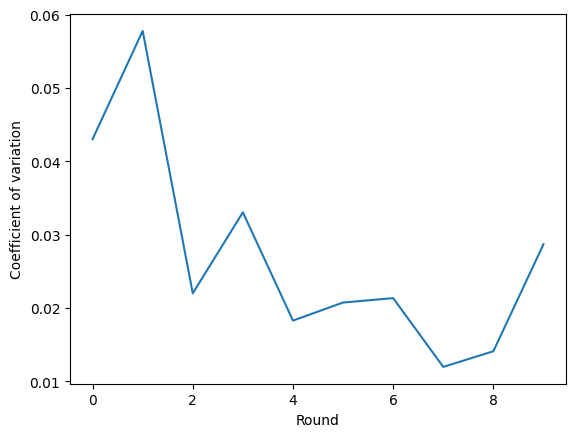

In [11]:
num_rounds = len(runs[0].losses_distributed)
losses_per_round = [[] for _ in range(num_rounds)]
accuracies_per_round = [[] for _ in range(num_rounds)]

for run in runs:
    for i,loss in run.losses_distributed:
        losses_per_round[i-1].append(loss)
    for i,acc in run.metrics_distributed["accuracy"]:
        accuracies_per_round[i-1].append(acc)

relative_loss_std = [np.std(losses, dtype=np.float64)/np.mean(losses,dtype=np.float64) for losses in losses_per_round]
relative_accuracy_std = [np.std(accuracies, dtype=np.float64)/np.mean(accuracies,dtype=np.float64) for accuracies in accuracies_per_round]

import matplotlib.pyplot as plt
plt.title("")
plt.plot(relative_loss_std)
plt.xlabel("Round")
plt.ylabel("Coefficient of variation ")
plt.show()

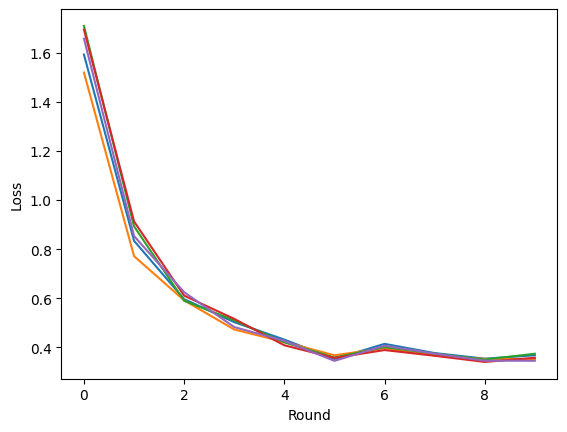

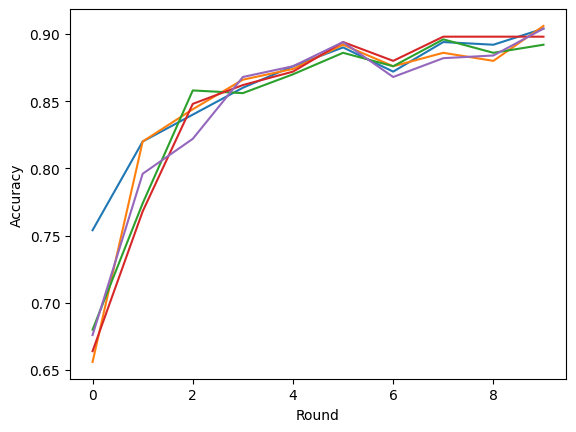

In [14]:
for run in runs:
    plt.plot([x[1] for x in run.losses_distributed])
plt.xlabel("Round")
plt.ylabel("Loss")
plt.show()

for run in runs:
    plt.plot([x[1] for x in run.metrics_distributed["accuracy"]])
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.show()